 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Convert-targets-to-categorical" data-toc-modified-id="Convert-targets-to-categorical-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convert targets to categorical</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Assign-observations-to-bins,-part-1:-Always-to-the-left" data-toc-modified-id="Assign-observations-to-bins,-part-1:-Always-to-the-left-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Assign observations to bins, part 1: Always to the left</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Assign-observations-to-bins,-part-2:-Nearest-edge" data-toc-modified-id="Assign-observations-to-bins,-part-2:-Nearest-edge-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Assign observations to bins, part 2: Nearest edge</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Bin-size-tuning" data-toc-modified-id="Bin-size-tuning-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Bin size tuning</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Full-ensemble-features" data-toc-modified-id="Full-ensemble-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Full ensemble features</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#With-convolution" data-toc-modified-id="With-convolution-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>With convolution</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Full-ensemble-with-mean-and-std-output" data-toc-modified-id="Full-ensemble-with-mean-and-std-output-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Full ensemble with mean and std output</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#With-station-embeddings" data-toc-modified-id="With-station-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>With station embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#testing-a-convolution-layer" data-toc-modified-id="testing-a-convolution-layer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>testing a convolution layer</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Auxiliary-data" data-toc-modified-id="Auxiliary-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Auxiliary data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Mean-and-std" data-toc-modified-id="Mean-and-std-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mean and std</a></span></li><li><span><a href="http://localhost:8888/notebooks/nn_postprocessing/categorical.ipynb#Full-ensemble" data-toc-modified-id="Full-ensemble-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Full ensemble</a></span></li></ul></li></ul></div>

# Categorical/binned output 

Here we will use categorical output instead of the mean and standard deviation.


In [211]:
# Imports
from importlib import reload
import utils; reload(utils)
from utils import *
import crps_loss; reload(crps_loss)
from crps_loss import maybe_correct_cat_crps, approx_crps_cat, crps_cost_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from scipy.stats import binned_statistic

Anaconda environment: cbrain
Linux 4.4.0-97-generic


In [43]:
# Setup
# DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU
fclt = 48

## Convert targets to categorical

We will one-hot-encode the target array

In [4]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates)

train set contains 365 days
test set contains 366 days


In [8]:
# Define the bins
bin_width = 0.5
bin_edges = np.arange(-30, 35 + bin_width, bin_width)
bin_edges.shape

(131,)

### Assign observations to bins, part 1: Always to the left

In [9]:
def convert_targets(targets, bin_edges):
    bin_idxs = binned_statistic(targets, targets, bins=bin_edges)[-1]
    return keras.utils.to_categorical(bin_idxs, num_classes=bin_edges.shape[0]-1)

In [10]:
train_cat_targets = convert_targets(train_set.targets, bin_edges)
test_cat_targets = convert_targets(test_set.targets, bin_edges)

Obs: 4.3


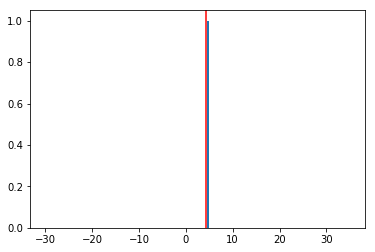

In [15]:
print('Obs:', test_set.targets[0])
plt.bar(bin_edges[:-1] + 0.25, test_cat_targets[0], width=0.5, zorder=0.1)
plt.axvline(test_set.targets[0], c='r')
plt.show()

In [103]:
def build_cat_model(n_features, hidden_nodes, n_bins):
    inp = Input(shape=(n_features,))
    x = Dense(hidden_nodes[0], activation='relu')(inp)
    if len(hidden_nodes) > 1:
        for h in hidden_nodes[1:]:
            x = Dense(h, activation='relu')(x)
    x = Dense(n_bins, activation='softmax')(x)
    return Model(inputs=inp, outputs=x)

In [46]:
model = build_cat_model(2, 50, bin_edges.shape[0]-1)

In [18]:
model.compile(optimizer=Adam(0.01), loss=approx_crps)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 130)               6630      
Total params: 9,330
Trainable params: 9,330
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_set.features, train_cat_targets, epochs=5, batch_size=4096,
          validation_data=[test_set.features, test_cat_targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/5
180849/180849 [==============================] - 2s - loss: 1.1393 - val_loss: 1.0635
Epoch 2/5
180849/180849 [==============================] - 2s - loss: 1.1401 - val_loss: 1.0704
Epoch 3/5
180849/180849 [==============================] - 2s - loss: 1.1401 - val_loss: 1.0587
Epoch 4/5
180849/180849 [==============================] - 2s - loss: 1.1417 - val_loss: 1.0665
Epoch 5/5
180849/180849 [==============================] - 2s - loss: 1.1387 - val_loss: 1.0673


In [23]:
preds = model.predict(test_set.features)

In [26]:
# Get correct CRPS
maybe_correct_cat_crps(preds, test_set.targets, bin_edges)

1.1011249457749939

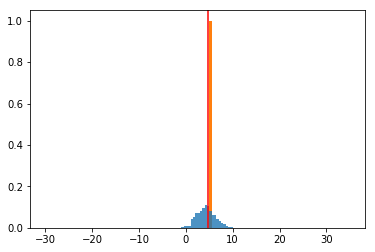

In [106]:
i = 40001
plt.bar(bin_edges[:-1] + 0.25, preds[i], width=0.5, alpha=0.8)
plt.bar(bin_edges[:-1] + 0.25, test_cat_targets[i], width=0.5, zorder=0.1)
plt.axvline(test_set.targets[i], c='r')
plt.show()

### Assign observations to bins, part 2: Nearest edge

In [22]:
def convert_targets_nearest(targets, bin_edges):
    mat_bin_edges = np.repeat(np.atleast_2d(bin_edges), targets.shape[0], axis=0).T
    bin_idxs = np.argmin(np.abs(mat_bin_edges - targets),axis=0)
    return keras.utils.to_categorical(bin_idxs, num_classes=bin_edges.shape[0]-1)

In [23]:
train_cat_targets_nearest = convert_targets_nearest(train_set.targets, bin_edges)
test_cat_targets_nearest = convert_targets_nearest(test_set.targets, bin_edges)

In [229]:
model = build_cat_model(2, [50], bin_edges.shape[0]-1)

In [234]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [235]:
model.fit(train_set.features, train_cat_targets_nearest, epochs=5, batch_size=1024,
          validation_data=[test_set.features, test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/5
180849/180849 [==============================] - 3s - loss: 1.1734 - val_loss: 1.1389
Epoch 2/5
180849/180849 [==============================] - 3s - loss: 1.1727 - val_loss: 1.1382
Epoch 3/5
180849/180849 [==============================] - 3s - loss: 1.1720 - val_loss: 1.1369
Epoch 4/5
180849/180849 [==============================] - 3s - loss: 1.1714 - val_loss: 1.1367
Epoch 5/5
180849/180849 [==============================] - 3s - loss: 1.1708 - val_loss: 1.1353


In [236]:
preds = model.predict(test_set.features)

In [237]:
maybe_correct_cat_crps(preds, test_set.targets, bin_edges)

1.1311971355100863

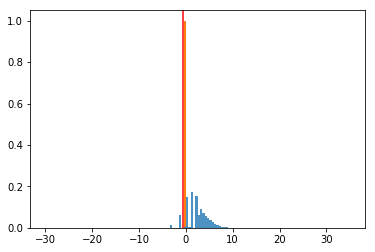

In [240]:
i = 10
plt.bar(bin_edges[:-1] + 0.25, preds[i], width=0.5, alpha=0.8)
plt.bar(bin_edges[:-1] + 0.25, test_cat_targets_nearest[i], width=0.5, zorder=0.1)
plt.axvline(test_set.targets[i], c='r')
plt.show()

### Bin size tuning

In [241]:
wide_bin_width = 1.5
wide_bin_edges = np.arange(-30, 35 + wide_bin_width, wide_bin_width)

In [242]:
wide_train_cat_targets = convert_targets_nearest(train_set.targets, wide_bin_edges)
wide_test_cat_targets = convert_targets_nearest(test_set.targets, wide_bin_edges)

In [243]:
model = build_cat_model(2, [50], wide_bin_edges.shape[0]-1)

In [244]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_62 (Dense)             (None, 44)                2244      
Total params: 2,394
Trainable params: 2,394
Non-trainable params: 0
_________________________________________________________________


In [253]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [254]:
model.fit(train_set.features, wide_train_cat_targets, epochs=5, batch_size=1024,
          validation_data=[test_set.features, wide_test_cat_targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/5
180849/180849 [==============================] - 2s - loss: 0.4007 - val_loss: 0.3866
Epoch 2/5
180849/180849 [==============================] - 2s - loss: 0.4000 - val_loss: 0.3857
Epoch 3/5
180849/180849 [==============================] - 2s - loss: 0.3994 - val_loss: 0.3850
Epoch 4/5
180849/180849 [==============================] - 2s - loss: 0.3988 - val_loss: 0.3844
Epoch 5/5
180849/180849 [==============================] - 2s - loss: 0.3983 - val_loss: 0.3841


In [255]:
preds = model.predict(test_set.features)

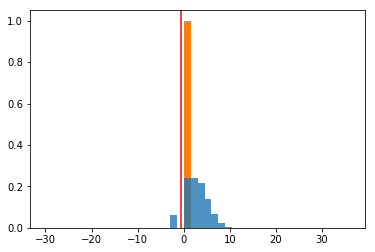

In [256]:
i = 10
plt.bar(wide_bin_edges[:-1] + 0.75, preds[i], width=1.5, alpha=0.8)
plt.bar(wide_bin_edges[:-1] + 0.75, wide_test_cat_targets[i], width=1.5, zorder=0.1)
plt.axvline(test_set.targets[i], c='r')
plt.show()

In [257]:
maybe_correct_cat_crps(preds, test_set.targets, wide_bin_edges)

1.2046557611208457

## Full ensemble features

In [62]:
train_set_full_ens, test_set_full_ens = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                                            full_ensemble_t=True)

train set contains 365 days
test set contains 366 days


In [64]:
train_set_full_ens.features.shape

(180849, 50)

In [181]:
model = build_cat_model(50, [50], bin_edges.shape[0]-1)

In [182]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 50)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_50 (Dense)             (None, 130)               6630      
Total params: 9,180
Trainable params: 9,180
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [186]:
model.fit(train_set_full_ens.features, train_cat_targets_nearest, epochs=10, batch_size=1024,
          validation_data=[test_set_full_ens.features, test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 3s - loss: 1.1662 - val_loss: 1.1399
Epoch 2/10
180849/180849 [==============================] - 3s - loss: 1.1656 - val_loss: 1.1393
Epoch 3/10
180849/180849 [==============================] - 3s - loss: 1.1651 - val_loss: 1.1394
Epoch 4/10
180849/180849 [==============================] - 3s - loss: 1.1646 - val_loss: 1.1383
Epoch 5/10
180849/180849 [==============================] - 3s - loss: 1.1641 - val_loss: 1.1380
Epoch 6/10
180849/180849 [==============================] - 3s - loss: 1.1637 - val_loss: 1.1378
Epoch 7/10
180849/180849 [==============================] - 3s - loss: 1.1632 - val_loss: 1.1371
Epoch 8/10
180849/180849 [==============================] - 3s - loss: 1.1628 - val_loss: 1.1367
Epoch 9/10
180849/180849 [==============================] - 3s - loss: 1.1625 - val_loss: 1.1362
Epoch 10/10
180849/180849 [==============================] - 3s - loss: 1.1

In [187]:
preds = model.predict(test_set_full_ens.features)

In [188]:
maybe_correct_cat_crps(preds, test_set.targets, bin_edges)

1.1306173910191841

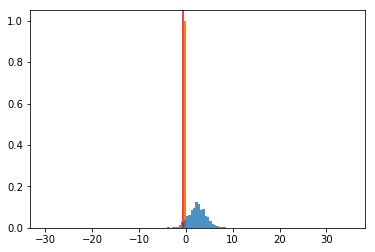

In [189]:
i = 10
plt.bar(bin_edges[:-1] + 0.25, preds[i], width=0.5, alpha=0.8)
plt.bar(bin_edges[:-1] + 0.25, test_cat_targets[i], width=0.5, zorder=0.1)
plt.axvline(test_set.targets[i], c='r')
plt.show()

### With convolution

In [190]:
def build_cat_conv_model(hidden_nodes, feature_size, n_bins, maps):
    features_in = Input(shape=(feature_size, 1))
    conv = Conv1D(maps, feature_size)(features_in)
    conv = Flatten()(conv)
    x = Dense(hidden_nodes, activation='relu')(conv)
    x = Dense(n_bins, activation='softmax')(x)
    model = Model(inputs=features_in, outputs=x)
    return model

In [200]:
model = build_cat_conv_model(50, 50, bin_edges.shape[0]-1, 10)

In [201]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 50, 1)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 10)             510       
_________________________________________________________________
flatten_13 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_56 (Dense)             (None, 130)               6630      
Total params: 7,690
Trainable params: 7,690
Non-trainable params: 0
_________________________________________________________________


In [204]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [205]:
model.fit(np.atleast_3d(train_set_full_ens.features), train_cat_targets_nearest, 
          epochs=10, batch_size=1024,
          validation_data=[np.atleast_3d(test_set_full_ens.features), test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 4s - loss: 1.1959 - val_loss: 1.1233
Epoch 2/10
180849/180849 [==============================] - 3s - loss: 1.1956 - val_loss: 1.1215
Epoch 3/10
180849/180849 [==============================] - 3s - loss: 1.1956 - val_loss: 1.1217
Epoch 4/10
180849/180849 [==============================] - 3s - loss: 1.1956 - val_loss: 1.1225
Epoch 5/10
180849/180849 [==============================] - 3s - loss: 1.1934 - val_loss: 1.1185
Epoch 6/10
180849/180849 [==============================] - 3s - loss: 1.1890 - val_loss: 1.1168
Epoch 7/10
180849/180849 [==============================] - 3s - loss: 1.1887 - val_loss: 1.1178
Epoch 8/10
180849/180849 [==============================] - 3s - loss: 1.1885 - val_loss: 1.1171
Epoch 9/10
180849/180849 [==============================] - 3s - loss: 1.1884 - val_loss: 1.1167
Epoch 10/10
180849/180849 [==============================] - 3s - loss: 1.1

### Full ensemble with mean and std output

In [113]:
def build_hidden_model(hidden_nodes, feature_size=2):
    inp = Input(shape=(feature_size,))
    x = Dense(hidden_nodes, activation='relu')(inp)
    x = Dense(2, activation='linear')(x)
    return Model(inputs=inp, outputs=x)

In [114]:
model = build_hidden_model(50, 50)
model.compile(optimizer=Adam(0.01), loss=crps_cost_function)

In [115]:
model.fit(train_set_full_ens.features, train_set_full_ens.targets, epochs=5, 
                 batch_size=1024,
                 validation_data=[test_set_full_ens.features, test_set_full_ens.targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/5
180849/180849 [==============================] - 1s - loss: 1.4411 - val_loss: 1.0460
Epoch 2/5
180849/180849 [==============================] - 1s - loss: 1.0766 - val_loss: 1.0239
Epoch 3/5
180849/180849 [==============================] - 1s - loss: 1.0731 - val_loss: 1.0242
Epoch 4/5
180849/180849 [==============================] - 1s - loss: 1.0711 - val_loss: 1.0422
Epoch 5/5
180849/180849 [==============================] - 1s - loss: 1.0709 - val_loss: 1.0318


In [116]:
preds = model.predict(test_set_full_ens.features)

In [118]:
preds[10], test_set_full_ens.targets[10]

(array([ 2.14922285, -1.70540333], dtype=float32), -0.60000002)

## With station embeddings

In [124]:
def build_cat_emb_model(hidden_nodes, emb_size, max_id, feature_size, n_bins):
    features_in = Input(shape=(feature_size,))
    id_in = Input(shape=(1,))
    emb = Embedding(max_id + 1, emb_size)(id_in)
    emb = Flatten()(emb)
    x = Concatenate()([features_in, emb])
    x = Dense(hidden_nodes, activation='relu')(x)
    x = Dense(n_bins, activation='softmax')(x)
    model = Model(inputs=[features_in, id_in], outputs=x)
    return model

In [125]:
emb_size = 5
max_id = int(np.max([train_set.cont_ids.max(), test_set.cont_ids.max()]))
max_id

536

In [135]:
model = build_cat_emb_model(100, emb_size, max_id, 2, bin_edges.shape[0]-1)

In [147]:
model.compile(optimizer=Adam(0.00001), loss=approx_crps)

In [148]:
model.fit([train_set.features, train_set.cont_ids], train_cat_targets_nearest, 
              epochs=10, batch_size=4096, 
              validation_data=[[test_set.features, test_set.cont_ids], test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 3s - loss: 0.9701 - val_loss: 0.9442
Epoch 2/10
180849/180849 [==============================] - 2s - loss: 0.9701 - val_loss: 0.9441
Epoch 3/10
180849/180849 [==============================] - 2s - loss: 0.9701 - val_loss: 0.9440
Epoch 4/10
180849/180849 [==============================] - 2s - loss: 0.9700 - val_loss: 0.9440
Epoch 5/10
180849/180849 [==============================] - 2s - loss: 0.9700 - val_loss: 0.9439
Epoch 6/10
180849/180849 [==============================] - 2s - loss: 0.9700 - val_loss: 0.9439
Epoch 7/10
180849/180849 [==============================] - 2s - loss: 0.9700 - val_loss: 0.9438
Epoch 8/10
180849/180849 [==============================] - 2s - loss: 0.9700 - val_loss: 0.9438
Epoch 9/10
180849/180849 [==============================] - 2s - loss: 0.9700 - val_loss: 0.9437
Epoch 10/10
180849/180849 [==============================] - 2s - loss: 0.9

In [149]:
preds = model.predict([test_set.features, test_set.cont_ids])

In [150]:
maybe_correct_cat_crps(preds, test_set.targets, bin_edges)

0.95332045387173248

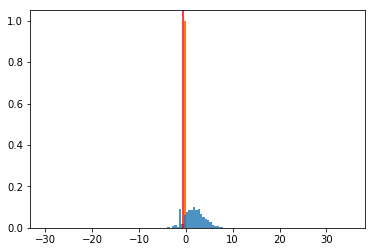

In [151]:
i = 10
plt.bar(bin_edges[:-1] + 0.25, preds[i], width=0.5, alpha=0.8)
plt.bar(bin_edges[:-1] + 0.25, test_cat_targets[i], width=0.5, zorder=0.1)
plt.axvline(test_set.targets[i], c='r')
plt.show()

### testing a convolution layer

In [153]:
from keras.layers import Conv1D

In [158]:
def build_cat_emb_conv_model(hidden_nodes, emb_size, max_id, feature_size, n_bins, maps):
    features_in = Input(shape=(feature_size, 1))
    id_in = Input(shape=(1,))
    emb = Embedding(max_id + 1, emb_size)(id_in)
    emb = Flatten()(emb)
    conv = Conv1D(maps, feature_size)(features_in)
    conv = Flatten()(conv)
    x = Concatenate()([conv, emb])
    x = Dense(hidden_nodes, activation='relu')(x)
    x = Dense(n_bins, activation='softmax')(x)
    model = Model(inputs=[features_in, id_in], outputs=x)
    return model

In [161]:
model = build_cat_emb_conv_model(100, emb_size, max_id, 50, bin_edges.shape[0]-1, 2)

In [162]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 50, 1)         0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 1, 2)          102         input_27[0][0]                   
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 5)          2685        input_28[0][0]                   
___________________________________________________________________________________________

In [166]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [167]:
model.fit([np.atleast_3d(train_set_full_ens.features), train_set_full_ens.cont_ids], 
          train_cat_targets_nearest, 
          epochs=10, batch_size=4096, 
          validation_data=[[np.atleast_3d(test_set_full_ens.features), test_set_full_ens.cont_ids], 
                           test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 3s - loss: 1.1204 - val_loss: 1.0730
Epoch 2/10
180849/180849 [==============================] - 2s - loss: 1.1179 - val_loss: 1.0703
Epoch 3/10
180849/180849 [==============================] - 2s - loss: 1.1158 - val_loss: 1.0683
Epoch 4/10
180849/180849 [==============================] - 2s - loss: 1.1138 - val_loss: 1.0658
Epoch 5/10
180849/180849 [==============================] - 2s - loss: 1.1119 - val_loss: 1.0634
Epoch 6/10
180849/180849 [==============================] - 2s - loss: 1.1102 - val_loss: 1.0619
Epoch 7/10
180849/180849 [==============================] - 2s - loss: 1.1086 - val_loss: 1.0601
Epoch 8/10
180849/180849 [==============================] - 2s - loss: 1.1071 - val_loss: 1.0581
Epoch 9/10
180849/180849 [==============================] - 2s - loss: 1.1057 - val_loss: 1.0567
Epoch 10/10
180849/180849 [==============================] - 2s - loss: 1.1

## Auxiliary data

### Mean and std

In [208]:
aux_dict = OrderedDict()
aux_dict['data_aux_geo_interpolated.nc'] = ['orog', 
                                            'station_alt', 
                                            'station_lat', 
                                            'station_lon']
aux_dict['data_aux_pl500_interpolated_00UTC.nc'] = ['u_pl500_fc',
                                                    'v_pl500_fc',
                                                    'gh_pl500_fc']
aux_dict['data_aux_pl850_interpolated_00UTC.nc'] = ['u_pl850_fc',
                                                    'v_pl850_fc',
                                                    'q_pl850_fc']
aux_dict['data_aux_surface_interpolated_00UTC.nc'] = ['cape_fc',
                                                      'sp_fc',
                                                      'tcc_fc']

In [212]:
train_set_aux, test_set_aux = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                                  aux_dict=aux_dict)

train set contains 365 days
test set contains 366 days


In [214]:
model = build_cat_model(train_set_aux.features.shape[1], [50], bin_edges.shape[0]-1)

In [215]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 24)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 50)                1250      
_________________________________________________________________
dense_58 (Dense)             (None, 130)               6630      
Total params: 7,880
Trainable params: 7,880
Non-trainable params: 0
_________________________________________________________________


In [223]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [224]:
model.fit(train_set_aux.features, train_cat_targets_nearest, epochs=5, batch_size=1024,
          validation_data=[test_set_aux.features, test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/5
180849/180849 [==============================] - 3s - loss: 1.0580 - val_loss: 1.0450
Epoch 2/5
180849/180849 [==============================] - 3s - loss: 1.0578 - val_loss: 1.0457
Epoch 3/5
180849/180849 [==============================] - 3s - loss: 1.0576 - val_loss: 1.0456
Epoch 4/5
180849/180849 [==============================] - 3s - loss: 1.0575 - val_loss: 1.0435
Epoch 5/5
180849/180849 [==============================] - 3s - loss: 1.0573 - val_loss: 1.0438


In [267]:
model = build_cat_emb_model(100, emb_size, max_id, train_set_aux.features.shape[1], 
                            bin_edges.shape[0]-1)

In [268]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_44 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_10 (Embedding)         (None, 1, 5)          2685        input_44[0][0]                   
____________________________________________________________________________________________________
input_43 (InputLayer)            (None, 24)            0                                            
____________________________________________________________________________________________________
flatten_16 (Flatten)             (None, 5)             0           embedding_10[0][0]               
___________________________________________________________________________________________

In [274]:
model.compile(optimizer=Adam(0.00001), loss=approx_crps)

In [275]:
model.fit([train_set_aux.features, train_set_aux.cont_ids], train_cat_targets_nearest, 
              epochs=10, batch_size=4096, 
              validation_data=[[test_set_aux.features, test_set_aux.cont_ids], 
                               test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 3s - loss: 0.9672 - val_loss: 0.9603
Epoch 2/10
180849/180849 [==============================] - 2s - loss: 0.9665 - val_loss: 0.9605
Epoch 3/10
180849/180849 [==============================] - 2s - loss: 0.9662 - val_loss: 0.9607
Epoch 4/10
180849/180849 [==============================] - 2s - loss: 0.9661 - val_loss: 0.9608
Epoch 5/10
180849/180849 [==============================] - 2s - loss: 0.9661 - val_loss: 0.9610
Epoch 6/10
180849/180849 [==============================] - 2s - loss: 0.9660 - val_loss: 0.9610
Epoch 7/10
180849/180849 [==============================] - 2s - loss: 0.9660 - val_loss: 0.9611
Epoch 8/10
180849/180849 [==============================] - 2s - loss: 0.9660 - val_loss: 0.9610
Epoch 9/10
180849/180849 [==============================] - 2s - loss: 0.9659 - val_loss: 0.9609
Epoch 10/10
180849/180849 [==============================] - 2s - loss: 0.9

### Full ensemble

In [226]:
train_set_aux_ens, test_set_aux_ens = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                                          aux_dict=aux_dict, 
                                                          full_ensemble_t=True)

train set contains 365 days
test set contains 366 days


In [276]:
train_set_aux_ens.features.shape

(180849, 72)

In [280]:
model = build_cat_emb_model(100, emb_size, max_id, train_set_aux_ens.features.shape[1], 
                            bin_edges.shape[0]-1)

In [285]:
model.compile(optimizer=Adam(0.0001), loss=approx_crps)

In [286]:
model.fit([train_set_aux_ens.features, train_set_aux_ens.cont_ids], train_cat_targets_nearest, 
              epochs=10, batch_size=4096, 
              validation_data=[[test_set_aux_ens.features, test_set_aux_ens.cont_ids], 
                               test_cat_targets_nearest])

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 3s - loss: 0.9205 - val_loss: 0.9256
Epoch 2/10
180849/180849 [==============================] - 2s - loss: 0.9202 - val_loss: 0.9257
Epoch 3/10
180849/180849 [==============================] - 2s - loss: 0.9201 - val_loss: 0.9260
Epoch 4/10
180849/180849 [==============================] - 2s - loss: 0.9199 - val_loss: 0.9251
Epoch 5/10
180849/180849 [==============================] - 2s - loss: 0.9197 - val_loss: 0.9258
Epoch 6/10
180849/180849 [==============================] - 2s - loss: 0.9195 - val_loss: 0.9262
Epoch 7/10
180849/180849 [==============================] - 2s - loss: 0.9194 - val_loss: 0.9250
Epoch 8/10
180849/180849 [==============================] - 2s - loss: 0.9193 - val_loss: 0.9260
Epoch 9/10
180849/180849 [==============================] - 2s - loss: 0.9191 - val_loss: 0.9249
Epoch 10/10
180849/180849 [==============================] - 2s - loss: 0.9

In [287]:
preds = model.predict([test_set_aux_ens.features, test_set_aux_ens.cont_ids])

In [288]:
maybe_correct_cat_crps(preds, test_set_aux_ens.targets, bin_edges)

0.92655730152299154